# Drive loading and getting the datasets

In [2]:
# from google.colab import drive
# import os

In [3]:
# drive_path = "/content/gdrive"
# drive.mount(drive_path)
# if os.path.exists(f'{drive_path}/MyDrive/medmnist'):
#   !echo "Making root medmnist directory"
#   !mkdir /root/.medmnist
#   !echo "Copying medmnist data from drive to the root directory"
#   !cp {os.path.join(drive_path,"MyDrive/medmnist/")+ "*"} /root/.medmnist/

# Installs and imports

In [4]:
# !pip install medmnist
import medmnist
from medmnist import INFO
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import copy
import pandas as pd
import warnings
from typing import Tuple, OrderedDict
import torch
from torch.optim import SGD
import random
from tqdm import tqdm
from sklearn.cluster import KMeans
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")
seed = 1

# Set the random seed for torch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Set the random seed for numpy
np.random.seed(seed)

# Set the random seed for Python's built-in random module
random.seed(seed)

# Transforms

In [5]:
import torchvision.transforms.functional as TF
resize = transforms.Resize((32, 32))
class ToSingleChannel(object):
    def __call__(self, img):
        return TF.rgb_to_grayscale(img)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset, idxs, transform=None) -> None:
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self) -> int:
        return len(self.idxs)

    def __getitem__(self, index):
        x, y = self.dataset[self.idxs[index]]
        return torch.tensor(x, requires_grad=True).permute((1, 2, 0)) if not type(x) == type(torch.tensor([1])) else x, torch.tensor(y)



def non_iid_partition(dataset, num_clients):
    """
    non I.I.D parititioning of data over clients
    Sort the data by the digit label
    Divide the data into N shards of size S
    Each of the clients will get X shards

    params:
      - dataset (torch.utils.Dataset): Dataset containing the pathMNIST Images
      - num_clients (int): Number of Clients to split the data between
      - total_shards (int): Number of shards to partition the data in
      - shards_size (int): Size of each shard
      - num_shards_per_client (int): Number of shards of size shards_size that each client receives

    returns:
      - Dictionary of image indexes for each client
    """

    if dataset[0][1].shape[0] != 1:
        from sklearn.cluster import KMeans
        # Create an array of arrays
        arr = np.array([np.array(target) for _, target in dataset])
        # Define the number of clusters
        n_clusters = num_clients
        # Create a KMeans instance
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        # Fit the KMeans model
        kmeans.fit(arr)
        # Get the labels for each array
        labels = kmeans.labels_
        # Get the indices of each data point in each cluster
        cluster_indices = {}
        for i in range(n_clusters):
            indices = np.where(labels == i)[0]
            cluster_indices[i] = indices
        return cluster_indices

    shards_size = 9
    total_shards = len(dataset) // shards_size
    num_shards_per_client = total_shards // num_clients
    shard_idxs = [i for i in range(total_shards)]
    client_dict = {i: np.array([], dtype='int64') for i in range(num_clients)}
    idxs = np.arange(len(dataset))
    # get labels as a numpy array
    data_labels = np.array([np.array(target).flatten()
                           for _, target in dataset]).flatten()
    # sort the labels
    label_idxs = np.vstack((idxs, data_labels))
    label_idxs = label_idxs[:, label_idxs[1, :].argsort()]
    idxs = label_idxs[0, :]

    # divide the data into total_shards of size shards_size
    # assign num_shards_per_client to each client
    for i in range(num_clients):
        rand_set = set(np.random.choice(
            shard_idxs, num_shards_per_client, replace=False))
        shard_idxs = list(set(shard_idxs) - rand_set)

        for rand in rand_set:
            client_dict[i] = np.concatenate(
                (client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
    return client_dict  # client dict has [idx: list(datapoint indices)


def iid_partition(dataset, clients):
    """
    I.I.D paritioning of data over clients
    Shuffle the data
    Split it between clients
    params:
      - dataset (torch.utils.Dataset): Dataset containing the PathMNIST Images
      - clients (int): Number of Clients to split the data between
    returns:
      - Dictionary of image indexes for each client
    """
    num_items_per_client = int(len(dataset)/clients)
    client_dict = {}
    image_idxs = [i for i in range(len(dataset))]
    for i in range(clients):
        client_dict[i] = set(np.random.choice(
            image_idxs, num_items_per_client, replace=False))
        image_idxs = list(set(image_idxs) - client_dict[i])
    return {i: list(t) for i, t in client_dict.items()}

# Model

In [7]:
'''VGG11/13/16/19 in Pytorch.'''

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, in_channels):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name], in_channels)
        self.classifier = nn.Linear(512, 40)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg, num_channels):
        layers = []
        in_channels = num_channels
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


# Hospitals

In [47]:
def flatten(l):
  return [item for sublist in l for item in sublist]

In [54]:
from torch.utils.data import SubsetRandomSampler, RandomSampler

class NormalClient():
    def __init__(self, id, config, dataset, data_idxs, test_idxs, ds_name) -> None:
        self.id = id
        self.config = config
        self.classes = len(INFO[ds_name]["label"])
        self.train_loader = DataLoader(dataset, sampler=data_idxs, batch_size=config["batch_size"])
        self.test_loader = DataLoader(dataset, sampler=test_idxs, batch_size=32)
        self.device = config["device"]
        self.raw_model = VGG
        self.len_test = len(test_idxs)
        self.lr = config["learning_rate"]
        self.local_epochs = config["local_epochs"]
        self.num_train_samples = len(data_idxs)
        self.ds_name = ds_name
        # self.train_loss_dict = {}
        self.total_data_points_trained_on = 0
        self.data_frame = pd.DataFrame(columns=["Accuracy", "Loss", "Sensitivity", "Specificity", "F1Score", "ValLoss"], index=list(range(config["global_epochs"]+1)))
#####
        self.num_times_chosen = 0


    def train(self, state_dict, roundnum, learning_rate):
        self.num_times_chosen += 1
        model = self.raw_model('VGG11', 1)
        model.load_state_dict(state_dict)
        model.train()
        model.to(self.device)
        optimizer = SGD(model.parameters(), learning_rate)
        train_loss = []
        loss_fn = nn.CrossEntropyLoss()
        for l_epoch in range(self.local_epochs):
            for x, y in self.train_loader:
                x = x.to(self.device)
                y = y.type(torch.LongTensor).to(self.device)
                optimizer.zero_grad()
                logits = model(x)
                loss = loss_fn(logits, y.squeeze(-1))
                loss.backward()
                optimizer.step()
                train_loss.append(loss.detach().item())
                self.total_data_points_trained_on += len(y)
        self.last_train_loss = train_loss
        model.to('cpu')
        self.sd = model.state_dict()
        self.score = self.compute_score()
        self.avg_loss = np.mean(train_loss)
        acc= self.test()
        return acc, self.avg_loss, model.state_dict()


    def compute_score(self):
        return calculate_client_score(self.last_train_loss)

    def test(self, train_before=False, raw=False):

        model = VGG('VGG11', 1)
        model.load_state_dict(self.sd)
        model.to(self.device)
        total_correct = 0
        model.eval()
        preds = []
        y = []
        val_loss = 0.0
        loss_fn = nn.CrossEntropyLoss()
        with torch.no_grad():
            for x, labels in self.test_loader:
                x=x.to(self.device)
                labels = labels.type(torch.LongTensor).to("cuda")
                logits = model(x)
                val_loss += loss_fn(logits ,labels.flatten()).detach().cpu().item()
                pred = np.argmax(logits.detach().cpu().numpy(), axis=1)
                total_correct += np.sum(np.equal(pred.flatten(), labels.detach().cpu().flatten().numpy()))
                preds.append(pred)
                y.append(labels.detach().cpu().flatten().numpy())
        val_loss /= len(y)
        accuracy = np.sum(np.array(flatten(preds)).flatten() == np.array(flatten(y)).flatten()) / 1404
        y = None
        preds = None
        gc.collect()
        torch.cuda.empty_cache()
        return accuracy

    def get_confusion_matrix(self):
      return confusion_matrix(np.array(flatten([1,2,3])).flatten(), np.array(flatten([2,2,3])).flatten())

In [9]:
def calculate_specificity_sensitivity_f1(cm, mean=False):
    num_classes = cm.shape[0]
    specificity = np.zeros(num_classes)
    sensitivity = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    for i in range(num_classes):
        # Extract true positive, true negative, false positive, and false negative values for the current class
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        # Calculate specificity for the current class
        specificity[i] = tn / (tn + fp) if (tn + fp) != 0 else 0

        # Calculate sensitivity for the current class
        sensitivity[i] = tp / (tp + fn) if tp + fn != 0 else 0

        # Calculate F1 score for the current class
        f1_score[i] = 2 * (tp) / (2 * tp + fp + fn) if (tp + fp + fn) != 0 else 0
    if not mean:
      return specificity, sensitivity, f1_score
    return np.mean(specificity), np.mean(sensitivity), np.mean(f1_score)

def make_and_truncate_confusion_matrix(true, pred, truncate=True):
    cm = confusion_matrix(true, pred)
    if not truncate:
      return np.nan_to_num(cm, nan=0)
    lower = np.min(true)
    upper = np.max(true)
    # Extract the square region
    return cm[lower:upper, lower:upper]

def raw_values_to_metrics(true, pred, truncate=False, mean=False):
  cm = make_and_truncate_confusion_matrix(true, pred, truncate=truncate)
  specificity, sensitivity, f1_score = calculate_specificity_sensitivity_f1(cm, mean=mean)
  accuracy = np.count_nonzero(pred == true) / len(pred)
  return accuracy, specificity, sensitivity, f1_score

In [10]:
def calculate_hospital_score(loss_values):
    # Compute the rate of convergence
    x = np.arange(0, len(loss_values))
    y = np.array(loss_values)
    slope , _ = np.polyfit(x, y, deg=1)

    # compute the standard deviation of the loss
    std, var = np.std(loss_values), np.var(loss_values)

    # Define a scoring formula that combines rate of convergence and stability
    # You can customize this formula based on your preferences
    return slope

# Server

In [55]:
import gc
import random
class Server:
    def __init__(self, config, data_dicts, test_data_dicts, clients_datasets, global_datasets, names, server_train_idxs, server_test_idxs):
        self.config = config
        self.data_dicts = data_dicts
        self.test_dicts = test_data_dicts
        self.clients_datasets = clients_datasets
        self.global_datasets = global_datasets
        self.model = VGG('VGG11', 1)
        self.names = names
        self.client_ids = [*data_dicts.keys()]
        self.participation_percent = config["participation_percent"]
        self.cluste2Frs = []
        self.sim = None

    ###### CHOOSING THE CLIENT ######
        self.client = NormalClient
        self.clients = []
        index = 0
        for i, client in enumerate(self.client_ids):
          self.clients.append(self.client(
              id=client,
              config=self.config,
              dataset=self.clients_datasets[index],
              data_idxs=self.data_dicts[client],
              test_idxs=self.test_dicts[client],
              ds_name=self.names[index]
              ))
          if i%10==9:
            index += 1
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.similarity_matrices = []
        self.trained = []

  ##### Server train and test indices ######
        self.train_idxs = server_train_idxs
        self.test_idxs = server_test_idxs
        self.num_train_samples = sum([len(i) for i in self.train_idxs])
        self.global_results_dict = {}
        self.data_frame = pd.DataFrame(columns=["Accuracy", "Loss", "Sensitivity", "Specificity", "F1Score", "ValLoss"], index=list(range(config["global_epochs"]+1)))
        self.logits = []
        self.total_data_points_trained_on = 0
        temp = []
        self.total_dataset = []
        for i, (_, dataset) in enumerate(zip(self.names, self.global_datasets)):
          dataloader = DataLoader(dataset, batch_size=1, sampler=self.train_idxs[i])
          for x, y in dataloader:
             self.total_dataset.append((x.squeeze(0),y.squeeze(0)))
        self.global_accuracies_dict = {}
        print("finished server intitialization")

    def test_locals(self):
        results = {id: [] for id in self.client_ids}
        for client in self.clients:
            results[client.id] = client.test()
        return results

    def aggregate_(self, wstate_dicts):
        total_weight = sum(weight for weight, _ in wstate_dicts.values())
        aggregated_state_dict = {}

        for model_id, (weight, state_dict) in wstate_dicts.items():
            for key, value in state_dict.items():
                if key not in aggregated_state_dict:
                    aggregated_state_dict[key] = torch.zeros_like(value)

                aggregated_state_dict[key] += weight * value

        for key in aggregated_state_dict.keys():
            aggregated_state_dict[key] = aggregated_state_dict[key].to(torch.float32) / total_weight

        return aggregated_state_dict

    def flatten_model(self, state_dict):
      flat = []
      for key in state_dict:
        flat.append(state_dict[key].flatten())
      return torch.cat(flat, dim=0)

    def cluster_dict_(self,states_dict):
      # flattening all the models
      models_things = {client_id: self.flatten_model(states_dict[client_id][1]) for client_id in states_dict.keys()}
      nans = []
      keys = list(models_things.keys())

      for key in keys:
        if models_things[key].isnan().any().item() or models_things[key].isinf().any().item():
          nans.append(key)
          del models_things[key]
      print(nans)
      clients_ids = list(models_things.keys())
      models_things = {client_id: flat/ torch.linalg.norm(flat) for client_id, flat in models_things.items()}
      # self.models = models_things
      # Compute the similarity matrix
      sim_matrix = []
      for client_id, model in models_things.items():
            pair_wise_similarity = []
            for other_client_id, model_other in models_things.items():
              pair_wise_similarity.append(torch.linalg.norm(model - model_other).cpu().item())
            sim_matrix.append(pair_wise_similarity)

      # this part is for debugging purposes
      self.sim = np.array(sim_matrix)
      self.similarity_matrices.append(np.array(sim_matrix))
      # Preprocessing the similarity matrix in order to avoid NaN values
      sim_matrix = np.array(sim_matrix)

      # Clustering the matrix
      kmeans = KMeans(n_clusters=5)
      kmeans.fit(sim_matrix)

      # Obtaining the clustered matrix for plotting
      cluster_labels = kmeans.predict(sim_matrix)
      take = np.argsort(cluster_labels)
      labels = kmeans.labels_
      sorted_similarity_matrix = sim_matrix[take]
      sorted_similarity_matrix = sorted_similarity_matrix[:, take]

      # Plotting after clustering
      print("Similarity matrix before clustering")
      plt.figure(figsize=(8,8))
      sns.heatmap(sim_matrix)
      plt.show()

      print("Similarity matrix after clustering")
      plt.figure(figsize=(8,8))
      sns.heatmap(sorted_similarity_matrix)
      plt.show()

      # Creating a dict of keys: cluster and values: list of client ids
      clusters = {cluster_id: [] for cluster_id in np.unique(cluster_labels)}


      cluster_ids = list(clusters.values())
      self.nans = nans
      for client_id_index, item in enumerate(cluster_labels):
        clusters[item].append(clients_ids[client_id_index])
      print()
      return clusters

    def aggregate_clusters(self,cluster_dict):
        cluster_state_dicts = {}
        # Aggregate each cluster seperately
        for cluster_id, client_ids in cluster_dict.items():
            wstate_dicts = {}
            for client_id in client_ids:
                wstate_dicts[client_id] = [self.clients[client_id].num_train_samples, self.clients[client_id].sd]
            aggregated_state_dict = self.aggregate_(wstate_dicts)
            cluster_state_dicts[cluster_id] = aggregated_state_dict
        return cluster_state_dicts # {cluster_id: aggregated_cluster_state_dict}

    def aggregate_cluster(self, clients_list):
          wstate_dicts = {}
          # print("to aggregate: clients_list", cluster_list)
          for client_id in clients_list:
               wstate_dicts[client_id] = [self.clients[client_id].num_train_samples, self.clients[client_id].sd]
          self.sd = wstate_dicts
          aggregated_state_dict = self.aggregate_(wstate_dicts)

          return aggregated_state_dict

    def test_clients_on_global(self, round_num, clients):
        results = {}
        self.global_accuracies_dict[round_num] = []
        for client_id in clients:
          true, pred = self.test_model_on_global_test_data(self.clients[client_id].sd, client_id, round_num)
          accuracy, specificity, sensitivity, f1_score =  raw_values_to_metrics(true, pred, truncate=False, mean=False)
          results[client_id] = {
            'accuracy': accuracy,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'f1_score': f1_score
          }

        self.global_results_dict[round_num] = results

    def test_model_on_global_test_data(self, m=None, client_id=0, epoch=0):
        true = []
        preds = []
        accuracy = {}
        sd = self.model.state_dict() if not m else m
        model = VGG("VGG11", 1)
        model.load_state_dict(sd)
        model.to(self.device)
        model.eval()
        with torch.no_grad():
          for i, (ds_name, dataset) in enumerate(zip(self.names, self.global_datasets)):
            dataloader = DataLoader(dataset, batch_size=32, sampler=self.test_idxs[i])
            correct = 0
            for x, y in dataloader:
              x = x.to('cuda')
              y = y.type(torch.LongTensor).to("cuda")
              logits = model(x)
              pred = np.argmax(logits.detach().cpu().numpy(), axis=1)
              preds.append(pred.flatten())
              true.append(y.cpu().numpy().flatten())
              # print(preds.flatten(), y.flatten())
              correct += np.count_nonzero(pred.flatten() == y.cpu().numpy().flatten())
              x = x.to("cpu")
              y = y.to("cpu")
            # accuracy[ds_name]= correct/ len(self.test_idxs[i])
            print("client_id", client_id, ":", accuracy)
        self.global_accuracies_dict[epoch].append(accuracy)
        model.to("cpu")
        if m == None:
          return accuracy
        return np.array(flatten(true)).flatten(), np.array(flatten(preds)).flatten()

    def determine_cluster_training_score(self, cluster, round_num):
        # Calculate stabilities for each model
        scores = []
        for client in cluster:
            client_loss = np.array(flatten(self.clients[client].train_loss_dict[round_num]))
            std_loss, var_loss = calculate_stability(client_loss)
            client_convergence_rate = calculate_rate_of_convergence(client_loss, 1, len(client_loss))
            scores.append(
                calculate_model_score(client_convergence_rate, std_loss)
            )
        return [np.sum(scores)]

    def determine_sequential_order(self, clusters, round_num):
        clusters_scores = {}
        for i, cluster in enumerate(clusters):
            clusters_scores[i] = self.determine_cluster_training_score(cluster, round_num)
        sorted_clusters = sorted(clusters_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_clusters

    def aggregate_two_sd(self, sd1, sd2):
      result = {}
      for key, value in sd1.items():
        if key not in result:
          result[key] = torch.zeros_like(value)
        result[key].data.add_(value)
      for key, value in sd2.items():
        if key not in result:
          result[key] = torch.zeros_like(value)
        result[key].data.add_(value)
        result[key].data = result[key].data / 2
      return result

    def train_prev_server_on_global(self, roundnum, epochs=4, learning_rate=0.00001):
        previous_model = VGG("VGG11", 1)
        previous_model.load_state_dict(self.previous_model.state_dict())
        previous_model.to("cuda")
        self.previous_model = previous_model
        self.previous_model.train()
        self.previous_model.to(self.device)
        optimizer = SGD(self.previous_model.parameters(), learning_rate)
        train_loss = []
        self.logits.append([])
        dataloader = DataLoader(self.total_dataset, batch_size=32, shuffle=True)
        loss_fn = nn.CrossEntropyLoss()
        for e in range(epochs):
          for x, y in dataloader:
            x = x.to(self.device)
            y = y.to(self.device)
            optimizer.zero_grad()
            logits = self.previous_model(x)
            loss = loss_fn(logits, y.squeeze(-1))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().item())
            self.total_data_points_trained_on += len(y)
            # print(loss.item())
        self.last_train_loss = train_loss
        self.avg_loss = np.mean(train_loss)
        self.data_frame.loc[roundnum, "Loss"] = np.mean(train_loss)
        gc.collect()
        torch.cuda.empty_cache()
        return

    def train(self, k=None):
        epochs = self.config["global_epochs"]
        self.avg_loss_arr = [np.nan for _ in range(epochs)]
        self.avg_acc_arr = [np.nan for _ in range(epochs)]
        self.avg_loss_arr_std = [np.nan for _ in range(epochs)]
        self.upper = [np.nan for _ in range(epochs)]
        self.lower = [np.nan for _ in range(epochs)]
        ylim = 4
        learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
        # first round of training is meant for clustering, training clients for long epochs so we have good clusters
        self.clusters = []
        states_dict = {}
        print("Number of communication rounds is ", epochs)
        # training all the clients for N epochs
        # Selecting all the clients
        clients = [client.id for client in self.clients]
        # adding the selected clients to self.trained, a list where we store all the selected clients
        self.trained.append(clients)

        for i, client_id in enumerate(clients):
            # We change this if we need to do more epochs for the clustering round
            # self.clients[client_id].config["local_epochs"] = 1
            # Synchronizing all clients with the server, same initial model
            # self.clients[client_id].model.load_state_dict(self.model.state_dict())
            # training client, roundnum=0 is for client.data_frame to store the values correctly
            w, local_update = self.clients[client_id].train(self.model.state_dict(),roundnum=0, learning_rate=0.00001)
            # self.avg_loss.append(server.clients[client_id].avg_loss)

        # At this point we trained all clients for N number of local epochs and we have their models
        # We cluster the models parameters using kmeans
        self.cluster_dict = self.cluster_dict_({client.id: [client.num_train_samples, client.sd] for client in self.clients})
        # We obtain self.cluster_dict = {cluster_id: [id1, id2..], ..}

        # Each clients gets assigned an attribute cluster_id, corresponding to it's own cluster id
        for cluster_id, cluster in self.cluster_dict.items():
          for client_id in cluster:
            self.clients[client_id].cluster_id = cluster_id

        # In case we need this later, we obtain cluster scores and sort the cluster acordingly
        # for each cluster,  compute the cluster score -> self.cluster_scores = {
        #   cluster_id: sum of that clusters' clients score
        # }

        self.datasets_averages_global_accuracies = {ds: [] for ds in self.names}
        self.cluster_scores = {cluster_id: sum(
            [
                self.clients[client].score for client in cluster
            ]
        ) for cluster_id, cluster in self.cluster_dict.items()}

        self.order = list(self.cluster_scores.values())

        # To keep track of clusters
        self.clusters.append(self.cluster_dict)

        self.sorted_clients = []
        self.previous_model = VGG("VGG11", 1)
        # We start our normal training
        for i, epoch in tqdm(enumerate(range(1, epochs+1))):
            self.avg_loss = []
            # Optimization purposes
            torch.cuda.empty_cache()
            gc.collect()
            self.previous_model.load_state_dict(self.model.state_dict())
            # Choosing a fraction of clients
            clients = random.sample([client.id for client in self.clients], int(len(self.clients)* self.participation_percent))
            # We keep track of chosen clients
            self.trained.append(clients)

            # In case we want to train clients sequentially but ordered, we obtain chosen clients' scores,
            # and we sort them, and that's the order in which we train
            client_ids_scores = {id: self.clients[id].score for id in clients}
            sorted_client_ids = sorted(client_ids_scores.keys(), key=lambda x: client_ids_scores[x], reverse=True)
            self.sorted_clients.append(sorted_client_ids)

            # Given clients chosen A, A_i is the ith client, we create "clusters_dict", a dict containing {cluster_id: [A_i if A_i.cluster_id == cluster_id]}
            # Basically this dict will contain clusters, and clients that are chosen and belonging to that cluster
            self.clusters_dict = {cluster_id: [] for cluster_id in self.cluster_dict}
            for client_id in clients:
                self.clusters_dict[self.clients[client_id].cluster_id].append(client_id)

            states_dict = None
            gc.collect()
            states_dict = {}
            # We loop of the clusters, each cluster we train all the clients inside of it
            for j, (cluster_id, cluster_list) in enumerate(self.clusters_dict.items()):
                if len(cluster_list) == 0:
                  continue
                for client in cluster_list:
                    self.clients[client].train(self.model.state_dict(),roundnum=epoch, learning_rate=learning_rates[j])
                    self.avg_loss.append(self.clients[client].avg_loss)
                # We aggregate the cluster to obtain a cluster model, it's then synchronized with the server, and for the next cluster we broadcast the previous cluster's model
                self.model.load_state_dict(self.aggregate_cluster(cluster_list))
            learning_rates = [0.00001 for _ in learning_rates]
            # Global test on global test set
            self.test_clients_on_global(epoch, self.trained[-1])
            self.train_prev_server_on_global(epoch, epochs=self.config["server_epochs"], learning_rate=0.00001)
            self.model.to(self.device)
            self.previous_model.to(self.device)
            self.model.load_state_dict(
                  self.aggregate_two_sd(self.model.state_dict(), self.previous_model.state_dict())
                )
            acc, spec, sens, f1, val_loss = self.test()
            self.data_frame.loc[epoch, "Sensitivity"] = sens
            self.data_frame.loc[epoch, "Specificity"] = spec
            self.data_frame.loc[epoch, "Accuracy"] = acc
            self.data_frame.loc[epoch, "F1Score"] = f1
            self.data_frame.loc[epoch, "ValLoss"] = val_loss
            ########### PLOTTING ###########

            # Plotting the loss
            self.avg_loss_arr[i] = np.mean(self.avg_loss)

            # Getting the upper and lower bounds of the std of the loss
            self.avg_loss_arr_std[i] = np.std(self.avg_loss)
            self.upper[i] = self.avg_loss_arr[i] + self.avg_loss_arr_std[i]
            self.lower[i] = self.avg_loss_arr[i] - self.avg_loss_arr_std[i]

            # updating the size of the loss plot
            ymax = max([*self.upper]) + 1
            ylim = max(ylim, ymax)
            clear_output(wait=True)

            # plotting loss and std
            plt.figure(figsize=(10,8))
            plt.ylim(0, ylim)
            plt.xlim(0, epochs)
            plt.plot(list(range(epochs)), self.avg_loss_arr, color="C0", label="Loss")
            plt.fill_between(list(range(epochs)), self.lower, self.upper, alpha=0.5, color="C0", label="± std of loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title(f"Average Loss for clients trained until round {epoch}")
            plt.legend(loc="upper right")
            plt.show()

            # Updating the accuracy array
            self.avg_acc_arr[i] = get_mean_accuracy_for_group(server=self, group=self.trained[-1], round=i)

            # plotting average test accuracy
            plt.figure(figsize=(10,8))
            plt.plot(self.avg_acc_arr, label="Average test accuracy for trained clients at that round", color="orange")
            plt.ylim(0,1)
            plt.xlim(0,epochs)
            plt.legend(loc="lower right")
            plt.show()

            self.global_accuracies = [np.mean([client['accuracy'] for client in group.values()]) for group in self.global_results_dict.values()]
            plt.figure(figsize=(10,8))
            plt.plot(self.global_accuracies, label="Global accuracy")
            plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
            plt.xlim(0,epochs)
            plt.ylim(0,1)
            plt.legend()
            plt.show()
            # self.trained[-1]
            # self.global_accuracies_dict[epoch].append(accuracy)
            for ds in self.names:
              self.datasets_averages_global_accuracies[ds].append(
                  np.mean([
                      [result[ds] for result in self.global_accuracies_dict[epoch]]
                  ])
              )

            plt.figure(figsize=(10, 8))
            for ds in self.names:
              plt.plot(self.datasets_averages_global_accuracies[ds], label=ds)
            plt.title("Global test results per dataset")
            plt.ylim(0,0.7)
            plt.xlim(0,epochs)
            plt.xlabel("Epochs")
            plt.legend()
            plt.ylabel("Accuracy")
            plt.show()


    def test(self, train_before=False, raw=False):
        # one training pass before testing
        loss_fn = nn.CrossEntropyLoss()
        if train_before:
          optimizer = SGD(self.model.parameters(), self.config["learning_rate"])
          self.model.train()
          self.model.to(self.device)
          for x, y in self.train_loader:
              x = x.to(self.device)
              y = y.type(torch.LongTensor).to("cuda")
              optimizer.zero_grad()
              logits = self.model(x)
              loss = loss_fn(logits, y.squeeze(-1))
              loss.backward()
              optimizer.step()
        self.model.to(self.device)
        total_correct = 0
        self.model.eval()
        preds = []
        y = []
        val_loss = 0.0
        with torch.no_grad():
          for i, (ds_name, dataset) in enumerate(zip(self.names, self.global_datasets)):
            dataloader = DataLoader(dataset, batch_size=32, sampler=self.test_idxs[i])
            correct = 0
            for x, labels in dataloader:
              x = x.to('cuda')
              labels = labels.type(torch.LongTensor).to("cuda")
              logits = self.model(x)
              pred = np.argmax(logits.detach().cpu().numpy(), axis=1)
              val_loss += loss_fn(logits ,labels.flatten()).detach().cpu().item( )
              preds.append(pred.flatten())
              y.append(labels.cpu().numpy().flatten())

        val_loss /= len(y)
        accuracy, specificity, sensitivity, f1_score = raw_values_to_metrics(np.array(flatten(y)), np.array(flatten(preds)), truncate=False, mean=False)
        return accuracy, specificity, sensitivity, f1_score, val_loss

In [12]:
def calculate_rate_of_convergence(loss_values):
    x = np.arange(0, len(range_values))
    y = np.array(loss_values)

    slope, _ = np.polyfit(x, y, deg=1)
    return slope

def calculate_stability(loss_values):
    return np.std(loss_values), np.var(loss_values)

def calculate_model_score(rate, std):
    # Define a scoring formula that combines rate of convergence and stability
    # You can customize this formula based on your preferences
    return rate - (0.5 * std)

# Data partitioning

In [13]:
tranformations = transforms.Compose([ToSingleChannel(),resize, transforms.ToTensor()])

In [14]:
datasets = ["organamnist", "octmnist", "bloodmnist", "pathmnist", "tissuemnist"]
pads = {ds_name: len(INFO[ds_name]["label"]) for ds_name in datasets}
datasets_data = [getattr(medmnist, INFO[i]["python_class"]) for i in datasets]
five_datasets = []
server_datasets = []
pad = 0
clients_indexes = []
max_dataset_size = 22000
for ds_name, dataset in zip(datasets, datasets_data):
  # Concatenate tarin test and validation
  five_datasets.append([*dataset(root="data/", download=True, split="train",transform=tranformations, as_rgb=False),
                        *dataset(root="data/", download=True, split="test",transform=tranformations, as_rgb=False),
                        *dataset(root="data/", download=True, split="val",transform=tranformations, as_rgb=False)][:max_dataset_size])
  # Shuffle the added dataset
  random.shuffle(five_datasets[-1])

  # add padding to the labels
  five_datasets[-1] = [(a, i+pad) for a, i in five_datasets[-1]]
  pad += pads[ds_name]

  # Split data 20% for server, 80% for clients
  point_two_index = int(len(five_datasets[-1]) * 0.2)
    # Getting server's data
  server_datasets.append(five_datasets[-1][:point_two_index])
    # Getting clients' data
  five_datasets[-1] = five_datasets[-1][point_two_index:]

  # paritioning data into a 10 iid values
  clients_indexes += list(non_iid_partition(five_datasets[-1], 10).values())

Using downloaded and verified file: data/organamnist.npz


Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/octmnist.npz
Using downloaded and verified file: data/octmnist.npz
Using downloaded and verified file: data/octmnist.npz
Using downloaded and verified file: data/bloodmnist.npz
Using downloaded and verified file: data/bloodmnist.npz
Using downloaded and verified file: data/bloodmnist.npz
Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/tissuemnist.npz
Using downloaded and verified file: data/tissuemnist.npz
Using downloaded and verified file: data/tissuemnist.npz


In [15]:
def get_fold_data(data_indices, fold_number, num_folds):
    fold_size = len(data_indices) // num_folds
    start_index = fold_number * fold_size
    end_index = start_index + fold_size

    if fold_number == num_folds - 1:
        test_data = data_indices[start_index:]
    else:
        test_data = data_indices[start_index:end_index]

    train_data = np.concatenate((data_indices[:start_index], data_indices[end_index:]))

    return train_data, test_data

In [16]:
def all_client_indexes_to_train_and_test_dicts(all_indexes_list, fold_number, num_folds):
  data_dict = {}
  test_dict = {}
  for client_id, client_idxs in enumerate(all_indexes_list):
    data_dict[client_id], test_dict[client_id] = get_fold_data(client_idxs, fold_number, num_folds)
  return data_dict, test_dict

In [17]:
def get_train_and_test_idxs_for_server(datasets_len, fold_number, num_folds):
  indexes = []
  for ds_len in datasets_len:
    indexes.append(get_fold_data(list(range(ds_len)), fold_number, num_folds))
  return [train_and_test_indices_for_dataset[0] for train_and_test_indices_for_dataset in indexes], [train_and_test_indices_for_dataset[1] for train_and_test_indices_for_dataset in indexes]

In [18]:
# if not os.path.exists(os.path.join(drive_path,"MyDrive/medmnist/")):
#   !mkdir {os.path.join(drive_path,"MyDrive/medmnist/")}
# !cp /root/.medmnist/* {os.path.join(drive_path,"MyDrive/medmnist/")}

# Configuration dict

In [19]:
# from models import CNN
import torch.nn as nn

config = {
          'batch_size': 50,
          'device': 'cuda:0',
          'global_epochs': 30,
          'learning_rate': 0.00001,
          'local_epochs': 1,
          'participation_percent': 0.3,
          'server_epochs': 2,
          'seed': 1,
          }

# Utility functions

In [20]:
def flatten(l):
  return [item for sublist in l for item in sublist]

In [21]:
def get_mean_accuracy_for_group(server, group, round):
  return np.mean([server.clients[i].data_frame["Accuracy"][round+1] for i in group])

In [22]:
def calculate_specificity_sensitivity_f1(cm, mean=False):
    num_classes = cm.shape[0]
    specificity = np.zeros(num_classes)
    sensitivity = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        # Extract true positive, true negative, false positive, and false negative values for the current class
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        # Calculate specificity for the current class
        specificity[i] = tn / (tn + fp)

        # Calculate sensitivity for the current class
        sensitivity[i] = tp / (tp + fn)

        # Calculate F1 score for the current class
        f1_score[i] = 2 * (tp) / (2 * tp + fp + fn)

    if not mean:
      return specificity, sensitivity, f1_score
    return np.mean(specificity), np.mean(sensitivity), np.mean(f1_score)

In [23]:
def make_and_truncate_confusion_matrix(true, pred, truncate=True):
    cm = confusion_matrix(np.array(true).flatten(), np.array(true).flatten())
    if not truncate:
      return cm
    lower = min(true)
    upper = max(true)

    # Extract the square region
    return cm[lower:upper, lower:upper]

In [24]:
import matplotlib.pyplot as plt
import numpy as np

class ServerInformation:
  def __init__(self, server):
    self.config = server.config
    self.num_epochs = server.config["global_epochs"]
    self.local_accuracies = {
        client.id: client.data_frame.Accuracy.tolist() for client in server.clients
    }

    self.local_sensitivities = {
        client.id: client.data_frame.Sensitivity.tolist() for client in server.clients
    }

    self.local_specificities = {
        client.id: client.data_frame.Specificity.tolist() for client in server.clients
    }
    self.local_f1_scores = {
        client.id: client.data_frame.F1Score.tolist() for client in server.clients
    }

    self.clients_average_losses = {
        client.id: client.data_frame.Loss.tolist() for client in server.clients
    }
    self.trained = server.trained
    
    self.val_losses = {
        client.id: client.data_frame.ValLoss.tolist() for client in server.clients
    }
    # print(server.global_results_dict)
    self.global_accuracies = [[client['accuracy'] for client in group.values()] for group in server.global_results_dict.values()]
    self.global_specifcities = [[np.mean(client['specificity']) for client in group.values()] for group in server.global_results_dict.values()]
    self.global_sensitivities = [[np.mean(client['sensitivity']) for client in group.values()] for group in server.global_results_dict.values()]
    self.global_f1_scores = [[np.mean(client['f1_score']) for client in group.values()] for group in server.global_results_dict.values()]


  def compute_average(self, evaluation_metric_name, epoch):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if evaluation_metric_name == 'accuracy':
      evaluation_metric = self.local_accuracies

    elif evaluation_metric_name == 'sensitivity':
      evaluation_metric = self.local_sensitivities

    elif evaluation_metric_name == 'specificity':
      evaluation_metric = self.local_specificities

    elif 'f1' in evaluation_metric_name:
      evaluation_metric = self.local_f1_scores

    elif 'val' in evaluation_metric_name:
      evaluation_metric = self.val_losses

    elif 'loss' in evaluation_metric_name:
      evaluation_metric = self.clients_average_losses

    else:
      print('Metric doesnt exist')
    average = 0.0
    for i in self.trained[epoch]:
      average += np.mean(evaluation_metric[i][epoch])
    return average / len(self.trained[epoch])

  def get_average(self, evaluation_metric_name):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if evaluation_metric_name == 'accuracy':
      evaluation_metric = self.local_accuracies
      title = "Local accuracy during training"
      metric = "accuracy"

    elif evaluation_metric_name == 'sensitivity':
      evaluation_metric = self.local_sensitivities
      title = "Local senstivities during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "sensitivity"
      ylim = (0,1.1)

    elif evaluation_metric_name == 'specificity':
      evaluation_metric = self.local_specificities
      title = "Local specificities during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "specificity"
      ylim = (0,1.1)

    elif 'f1' in evaluation_metric_name:
      evaluation_metric = self.local_f1_scores
      title = "Local f1-score during training"
      evaluation_metric = np.array([[round_values for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
      metric = "f1-score"

    elif 'val' in evaluation_metric_name:
      evaluation_metric = self.val_losses
      metric = "Validation Loss"

    elif 'loss' in evaluation_metric_name:
      evaluation_metric = self.clients_average_losses
      metric = "Loss"

    elif 'acc' in evaluation_metric_name and 'global' in evaluation_metric_name:
      evaluation_metric = self.global_accuracy

    else:
      print('Metric doesnt exist')
      print(evaluation_metric_name)
      return
    arr_to_return = []
    for i, trained in enumerate(self.trained):
      round_value = []
      for client in trained:
        round_value.append(evaluation_metric[client][i])
      arr_to_return.append(np.mean([np.mean(i) for i in round_value]))

    return arr_to_return

  def plot_average(self, evaluation_metric_name, std=False):
    # x dict
    evaluation_metric_name = evaluation_metric_name.lower()
    if "global" not in evaluation_metric_name:
      if evaluation_metric_name == 'accuracy':
        evaluation_metric = self.local_accuracies
        title = "Local accuracy during training"
        metric = "accuracy"

      elif evaluation_metric_name == 'sensitivity':
        evaluation_metric = self.local_sensitivities
        title = "Local senstivities during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "sensitivity"
        ylim = (0,1.1)

      elif evaluation_metric_name == 'specificity':
        evaluation_metric = self.local_specificities
        title = "Local specificities during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "specificity"
        ylim = (0,1.1)

      elif 'f1' in evaluation_metric_name:
        evaluation_metric = self.local_f1_scores
        title = "Local f1-score during training"
        evaluation_metric = np.array([[np.mean(round_values) for round_values in client_values] for client_values in np.array(list(evaluation_metric.values()))])
        metric = "f1-score"
        ylim = (0,1.1)

      elif 'val' in evaluation_metric_name:
        evaluation_metric = self.val_losses
        title = "Local validation loss during training"
        metric = "Validation Loss"

      elif 'loss' in evaluation_metric_name:
        evaluation_metric = self.clients_average_losses
        title = "Average Loss during training"
        metric = "Loss"
    elif "global" in evaluation_metric_name:
        if 'acc' in evaluation_metric_name:
          evaluation_metric = self.global_accuracies
          title = "Global accuracy during training"
          ylabel = "Accuracy"
        elif 'speci' in evaluation_metric_name:
          evaluation_metric = self.global_specifcities
          title = "Global specificity during training"
          ylabel = "Specificity"
          ylim = (0, 1.1)
        elif 'sensit' in evaluation_metric_name:
          evaluation_metric = self.global_sensitivities
          title = "Global sensitivity during training"
          ylabel = "Sensitivity"
          ylim = (0, 1.1)
        elif 'f1' in evaluation_metric_name:
          evaluation_metric = self.global_f1_scores
          title = "Global f1-scores during training"
          ylabel = "f1-scores"
          ylim = (0, 1.1)
        else:
          print(f'Metric {evaluation_metric_name} doesnt exist')
          return

        if std:
          print("we only have the average values, no std ")
        evaluation_metric = np.array(evaluation_metric).mean(axis=0)
        print(np.array(evaluation_metric).shape)
        fig = plt.figure()
        plt.figure(figsize=(10,8))
        plt.plot(list(range(len(evaluation_metric))), evaluation_metric, label=title)
        plt.title(title)
        plt.xlabel("Training Epochs")
        plt.ylabel(ylabel)

        # Add a grid with custom colors
        plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
        plt.legend()
        ax = plt.gca()
        ax.set_facecolor((0,0,0,0.05))
        ax.set_xticks(list(range(0,len(evaluation_metric), len(evaluation_metric) // 4)))
        try:
          plt.ylim(*ylim)
        except NameError:
          pass
        plt.xlim(0, len(evaluation_metric)-1)
        plt.show()
        return
    else:
      print(f'Metric {evaluation_metric_name} doesnt exist')
      return
    # evaluation_metric = np.array(list(evaluation_metric.values()))
    arr_to_plot = []
    if std:
      std_values = []
    for i, trained in enumerate(self.trained):
      round_value = []
      for client in trained:
        round_value.append(evaluation_metric[client][i])
      if std:
        std_values.append(np.std(round_value))
      arr_to_plot.append(np.mean(round_value))

    if std:
      std_values = np.array(std_values)
      upper = arr_to_plot + std_values
      lower = arr_to_plot - std_values

    fig = plt.figure()
    plt.figure(figsize=(10,8))
    plt.plot(list(range(len(arr_to_plot))), arr_to_plot, label=title)
    if std:
      plt.fill_between(list(range(len(arr_to_plot))),upper, lower, color="C0", alpha=0.3, label="std of "+ title)
    plt.title(title)
    plt.xlabel("Training Epochs")
    plt.ylabel(metric)
    # Add a grid with custom colors
    plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
    plt.legend()
    ax = plt.gca()
    ax.set_facecolor((0,0,0,0.05))
    ax.set_xticks(list(range(0,len(arr_to_plot), len(arr_to_plot) // 4)))
    if std:
      plt.ylim(0, max(upper)+0.1)
    else:
      try:
        plt.ylim(*ylim)
      except NameError:
        pass
    plt.xlim(0, len(arr_to_plot)-1)
    plt.show()

  def plot_local_confusion_matrix(self):
    plt.figure(figsize=(10,8))
    sns.heatmap(self.local_confusion_matrix, cmap="YlGnBu", fmt=".2f")
    plt.title("Local test set Confusion matrix")
    plt.xlabel("Labels")
    plt.ylabel("Labels")
    plt.show()

  def summary_dict(self):
    return {
          "local_accuracies": self.get_average('accuracy'),
          "local_sensitivities": self.get_average('sensitivity'),
          "local_specificities": self.get_average('specificity'),
          "local_f1_scores": self.get_average('f1'),
          "local_val_losses": self.get_average('val'),
          "clients_average_losses": self.get_average('loss'),
          "global_accuracies": self.global_accuracies,
          "global_specifcities": self.global_specifcities,
          "global_sensitivities": self.global_sensitivities,
          "global_f1_scores": self.global_f1_scores
        }

  def __repr__(self):
    return str(self.summary_dict())

In [25]:
def get_local_accuracy_clustered(si):
    return [
        np.mean([
            si.local_accuracies[i][round] for i in group]) for round ,group in enumerate(si.trained)]

In [26]:
def get_average_loss_clustered(si):
    trained = si.trained
    result = []
    for i, group in enumerate(trained):
        result.append([])
        for client in group:
            result[-1].append(si.clients_average_losses[client][i])
        result[-1] = np.mean(result[-1])
    return result

In [27]:
def get_average_global_accuracy_with_no_dict(si):
    return np.mean(si.global_accuracies, axis=1)

# Running the experiment

In [56]:
# testing the cv thing
try:
  for client in server.clients:
    client.model = None
    client = None
    gc.collect()
    torch.cuda.empty_cache()
except (AttributeError, NameError):
  pass

server = None
gc.collect()
torch.cuda.empty_cache()
NUM_FOLDS = 5
k = 1

data_dict, test_dict = all_client_indexes_to_train_and_test_dicts(clients_indexes, k, NUM_FOLDS)
server_train_indices_per_dataset, server_test_indices_per_dataset =  get_train_and_test_idxs_for_server([len(dataset) for dataset in server_datasets], k, NUM_FOLDS)
server = Server(config=config, data_dicts=data_dict, test_data_dicts=test_dict, clients_datasets=five_datasets, global_datasets=server_datasets, names=datasets, server_train_idxs=server_train_indices_per_dataset, server_test_idxs=server_test_indices_per_dataset)
# server.train()

finished server intitialization


In [38]:
server.clients[0].num_train_samples

1404

In [ ]:
import pickle as pkl
si = ServerInformation(server)
si.global_results = server.global_results_dict
pickle_file_name = "experiment_result_file.pkl"
with open(pickle_file_name, "wb") as f:
    pkl.dump(si, f)

In [ ]:
with open(pickle_file_name, "rb") as f:
  results = pkl.load(f)

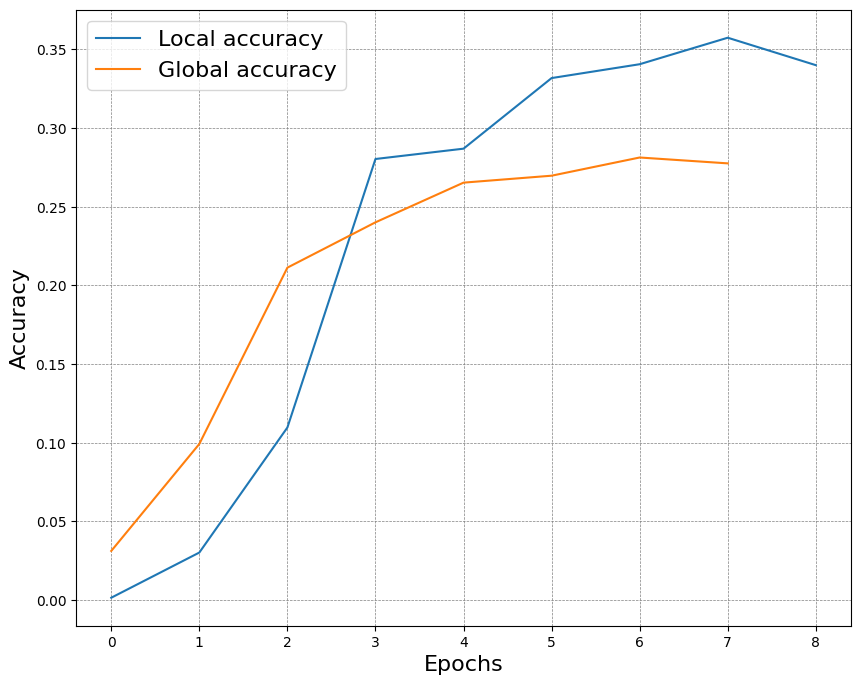

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
ax.plot(get_local_accuracy_clustered(results), label="Local accuracy")
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
plt.legend(fontsize=16)
# plt.show()
# fig, ax = plt.subplots(figsize=(10, 8))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
ax.plot(get_average_global_accuracy_with_no_dict(results), label="Global accuracy")
ax.set_ylabel("Accuracy", fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
plt.legend(fontsize=16)
plt.show()


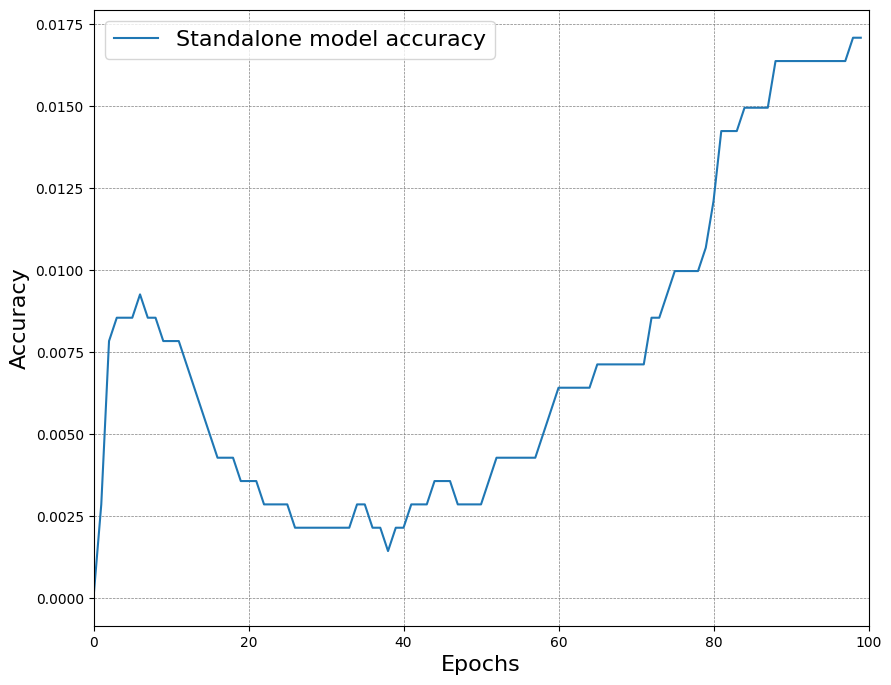

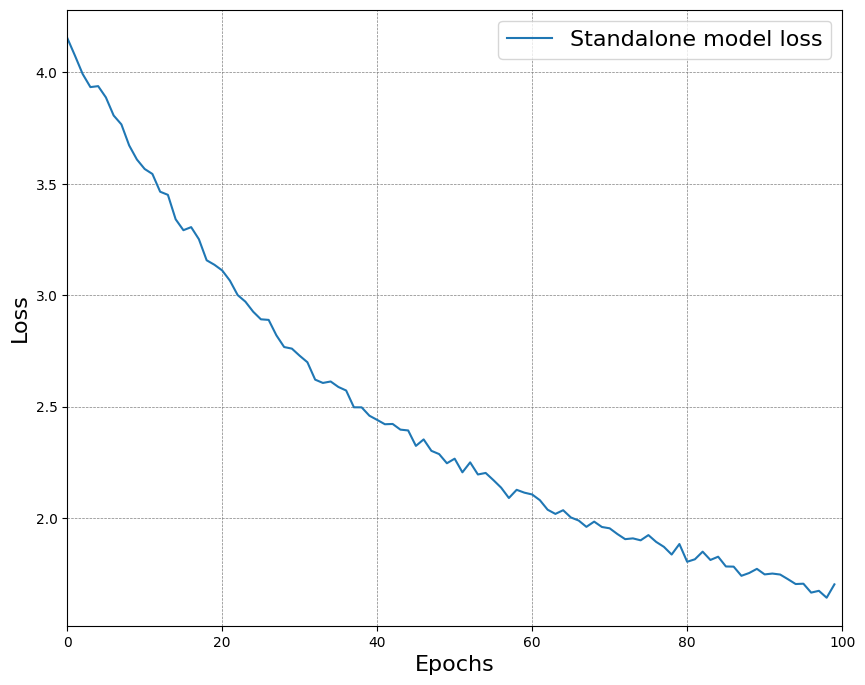

100%|██████████| 100/100 [07:40<00:00,  4.61s/it]


In [57]:
num_epochs = 100
    # def train(self, state_dict, roundnum, learning_rate):
# server.clients[0].data_frame.Accuracy = [np.nan for _ in range(len(server.clients[0].data_frame.Accuracy))]
model_sd = server.model.state_dict()
accuracies = [np.nan for _ in range(num_epochs)]
losses = [np.nan for _ in range(num_epochs)]
for epoch in tqdm(range(num_epochs)):
  acc, loss ,model_sd = server.clients[0].train(model_sd, epoch, 0.00001)
  accuracies[epoch] = acc
  losses[epoch] = loss
  clear_output(wait=True)
  fig, ax = plt.subplots(figsize=(10, 8))
  plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
  ax.plot(accuracies, label="Standalone model accuracy")
  ax.set_ylabel("Accuracy", fontsize=16)
  ax.set_xlabel("Epochs", fontsize=16)
  ax.set_xlim(0, num_epochs)
  plt.legend(fontsize=16)
  plt.show()
  fig, ax = plt.subplots(figsize=(10, 8))
  plt.grid(True, color='gray', linestyle='dashed', linewidth=0.5, zorder=1)
  ax.plot(losses, label="Standalone model loss")
  ax.set_ylabel("Loss", fontsize=16)
  ax.set_xlabel("Epochs", fontsize=16)
  plt.legend(fontsize=16)
  ax.set_xlim(0, num_epochs)
  plt.show()

In [45]:
def calculate_client_score(loss_values):
    # Compute the rate of convergence
    x = np.arange(0, len(loss_values))
    y = np.array(loss_values)
    slope , _ = np.polyfit(x, y, deg=1)

    # compute the standard deviation of the loss
    std, var = np.std(loss_values), np.var(loss_values)

    # Define a scoring formula that combines rate of convergence and stability
    # You can customize this formula based on your preferences
    return slope